In [1]:
import pandas as pd
from warnings import simplefilter

simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
from pathlib import Path
import json
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from datetime import datetime
import re
from scipy import stats
import numpy as np
import statsmodels.api as sm
import statsmodels
from matplotlib import colormaps
from tqdm.notebook import tqdm
import helpers
from collections import defaultdict
from tqdm.notebook import tqdm


from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.regression.linear_model import OLS

from mri_data import file_manager as fm

## Load Data

In [2]:
drive_root = fm.get_drive_root()
dataroot = drive_root / "3Tpioneer_bids"
data_dir = Path("/home/srs-9/Projects/ms_mri/data")
fig_path = Path(
    "/home/srs-9/Projects/ms_mri/analysis/thalamus/figures_tables/regression_plots"
)

choroid_volumes = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/choroid_aschoplex_volumes.csv", index_col="subid"
).dropna()
tiv = pd.read_csv("/home/srs-9/Projects/ms_mri/data/tiv_data.csv", index_col="subid")

df = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/clinical_data_processed.csv", index_col="subid"
)
sdmt = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/analysis/thalamus/SDMT_sheet.csv", index_col="subid"
)
df_thomas = pd.read_csv(data_dir / "hipsthomas_vols.csv", index_col="subid")

df = df.join([choroid_volumes, tiv, sdmt['SDMT'], df_thomas['1-THALAMUS']])
df['SDMT'] = pd.to_numeric(df['SDMT'], errors='coerce')
df.rename(columns={'1-THALAMUS': 'THALAMUS_1'}, inplace=True)

df_z = df.copy()
numeric_cols = df.select_dtypes(include='number').columns
df_z[numeric_cols] = df_z[numeric_cols].apply(stats.zscore, nan_policy="omit")

df_ms = df[df['dz_type2'] == "MS"]
df_ms_z = df_ms.copy()
df_ms_z[numeric_cols] = df_ms_z[numeric_cols].apply(stats.zscore, nan_policy="omit")

# assert df.loc[1340, 'EDSS'] == 2.5

viridis = colormaps['viridis'].resampled(20)

colors = helpers.get_colors()

## Functions

In [3]:
def compute_se_diff(se1, n1, se2, n2):
    return np.sqrt((se1**2/n1) + (se2**2/n2))

def scatter_hist(
    x, y, ax, ax_histx, ax_histy, nbins=10, light_color=None, dark_color=None
):
    if light_color is None:
        light_color = "#1f77b4"
    if dark_color is None:
        dark_color = "#1f77b4"

    # make axes look nice
    ax_histx.set_axis_off()
    ax_histy.set_axis_off()
    ax.xaxis.set_ticks_position("both")
    ax.yaxis.set_ticks_position("both")

    # the scatter plot:
    ax.scatter(x, y, color=dark_color)
    ylim = ax.get_ylim()

    # the histograms
    xbins = np.linspace(np.min(x), np.max(x), nbins)
    ybins = np.linspace(np.min(y), np.max(y), nbins)
    ax_histx.hist(x, bins=xbins, color="gray", density=True)
    ax_histy.hist(
        y, bins=ybins, orientation="horizontal", color=light_color, density=True
    )

    # kde to plot on histograms
    densityx = stats.gaussian_kde(x.dropna())
    densityy = stats.gaussian_kde(y.dropna())
    xx = np.linspace(np.min(x), np.max(x), 50)
    xy = np.linspace(np.min(y), np.max(y), 50)
    ax_histx.plot(xx, densityx(xx), color="black")
    ax_histy.plot(densityy(xy), xy, color=dark_color)
    
    ax_histy.set_ylim(ylim)


def plot_regression(
    data, predictor, outcome, covariates, xlabel=None, ylabel=None, title=None,
    color="blue1"
):
    plus_covariates = ""
    if len(covariates) > 0:
        plus_covariates = f"+ {' + '.join(covariates)}"
    if xlabel is None:
        xlabel = predictor
    if ylabel is None:
        ylabel = outcome
    if title is None:
        title = f"{outcome} vs {predictor}"
    
    light_color = colors[f"light {color}"]
    dark_color = colors[f"dark {color}"]

    formula = f"{outcome} ~ {predictor} {plus_covariates}"
    res = sm.OLS.from_formula(formula, data=data).fit()
    x, y_pred, y_lims = helpers.get_regression_y(data, res, predictor, outcome)

    fig, axs = plt.subplot_mosaic(
        [['histx', '.'], ['scatter', 'histy']],
        figsize=(8, 6),
        width_ratios=(4, 1),
        height_ratios=(1, 4),
        layout='constrained'
    )
    axs['scatter'].plot(x, y_pred, color="black")
    axs['scatter'].fill_between(
        x, y_lims[0], y_lims[1], alpha=0.4, color=light_color
    )
    scatter_hist(
        data[predictor],
        data[outcome],
        axs['scatter'],
        axs['histx'],
        axs['histy'],
        light_color=light_color,
        dark_color=dark_color,
    )

    axs['scatter'].set_ylabel(ylabel)
    axs['scatter'].set_xlabel(xlabel)
    fig.suptitle(title)
    return fig, axs

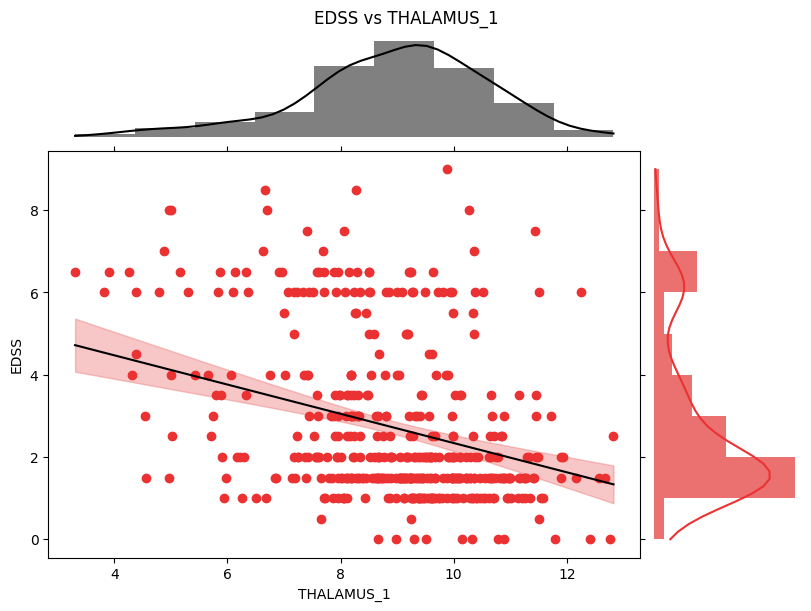

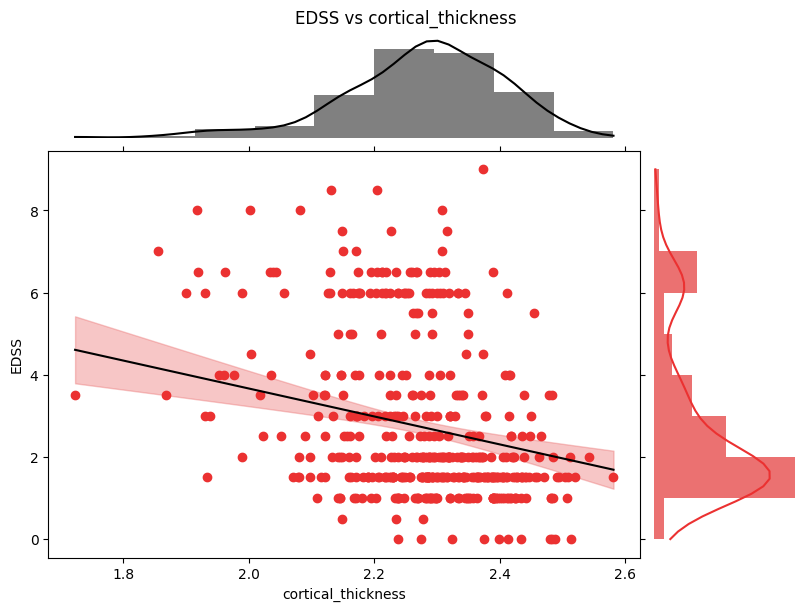

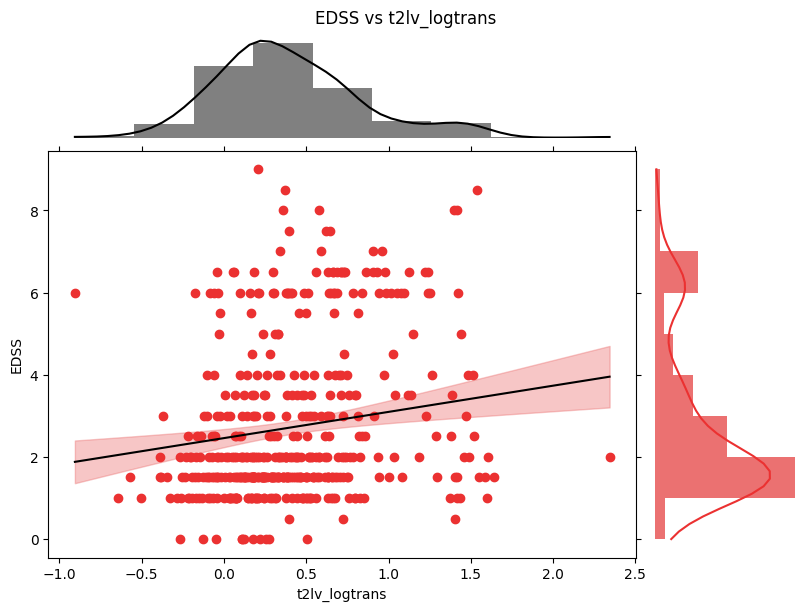

In [4]:
plot_data = df_ms.join([df_thomas])
plot_data['THALAMUS_1'] = plot_data['THALAMUS_1'] / 1000
covariates = ["age", "Female", "tiv"]

fig, axs = plot_regression(plot_data, "THALAMUS_1", "EDSS", covariates, color="red1")
# axs['scatter'].xaxis.set_major_formatter(plt.NullFormatter())
# axs['scatter'].set_ylim(ylim)
ylim = axs['scatter'].get_ylim()
plt.savefig(fig_path / "EDSS_v_thalamus.png", dpi=300)

fig, axs = plot_regression(plot_data, "cortical_thickness", "EDSS", covariates, color="red1")
# axs['scatter'].xaxis.set_major_formatter(plt.NullFormatter())
# ylim = axs['scatter'].get_ylim()
axs['scatter'].set_ylim(ylim)
axs['histy'].set_ylim(ylim)
plt.savefig(fig_path / "EDSS_v_cortical_thickness.png", dpi=300)

fig, axs = plot_regression(plot_data, "t2lv_logtrans", "EDSS", covariates, color="red1")
# axs['scatter'].xaxis.set_major_formatter(plt.NullFormatter())
axs['scatter'].set_ylim(ylim)
axs['histy'].set_ylim(ylim)
plt.savefig(fig_path / "EDSS_v_t2lv_logtrans.png", dpi=300)

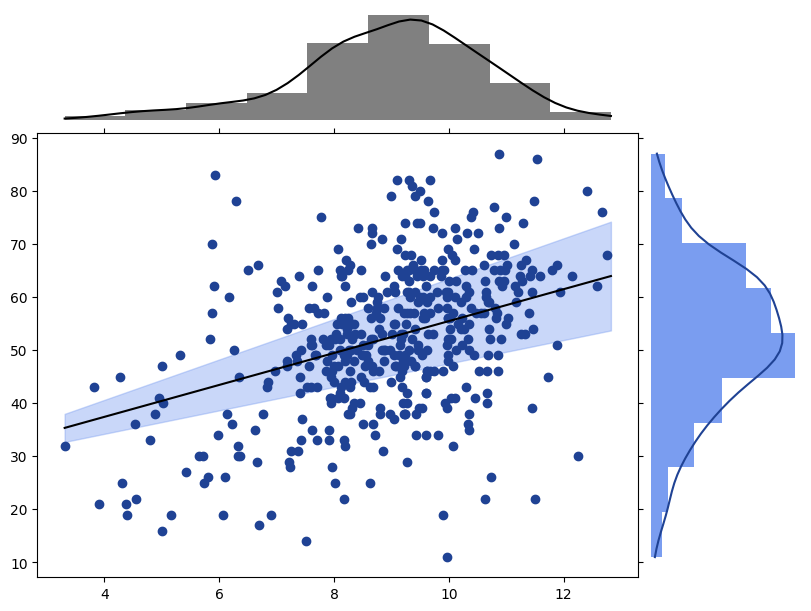

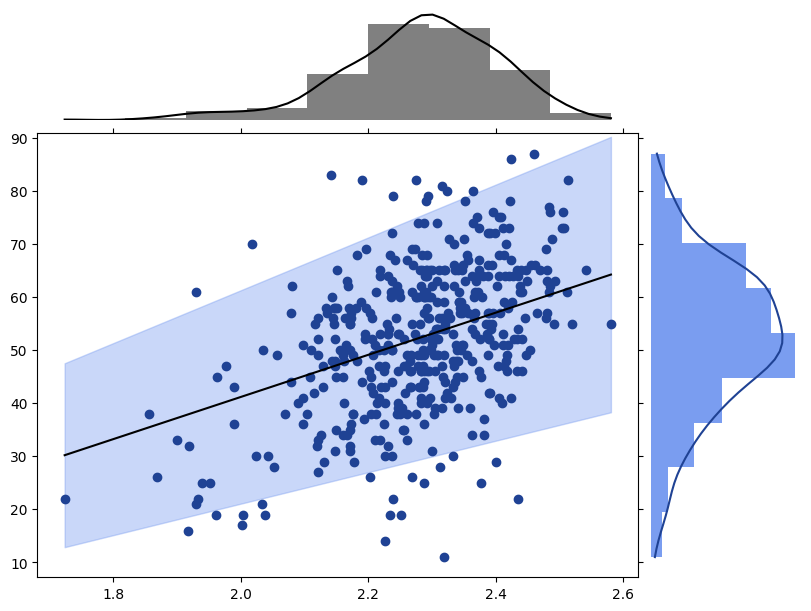

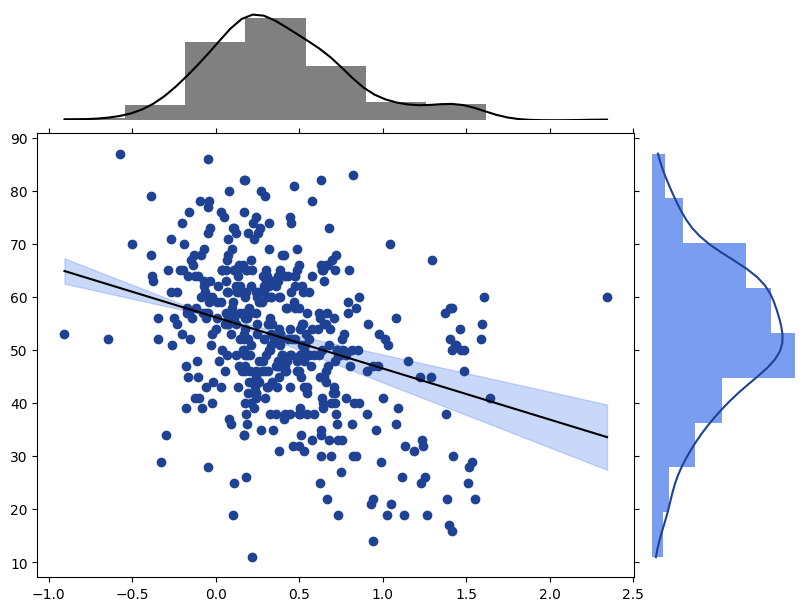

In [56]:
plot_data = df_ms.join([df_thomas])
plot_data['THALAMUS_1'] = plot_data['THALAMUS_1'] / 1000
covariates = ["age", "Female", "tiv"]

fig, axs = plot_regression(plot_data, "THALAMUS_1", "SDMT", covariates, color="blue1")
# axs['scatter'].xaxis.set_major_formatter(plt.NullFormatter())
# axs['scatter'].set_ylim(ylim)
ylim = axs['scatter'].get_ylim()
plt.savefig(fig_path / "SDMT_v_thalamus.png", dpi=300)

fig, axs = plot_regression(plot_data, "cortical_thickness", "SDMT", covariates, color="blue1")
# axs['scatter'].xaxis.set_major_formatter(plt.NullFormatter())
# ylim = axs['scatter'].get_ylim()
axs['scatter'].set_ylim(ylim)
axs['histy'].set_ylim(ylim)
plt.savefig(fig_path / "SDMT_v_cortical_thickness.png", dpi=300)

fig, axs = plot_regression(plot_data, "t2lv_logtrans", "SDMT", covariates, color="blue1")
# axs['scatter'].xaxis.set_major_formatter(plt.NullFormatter())
axs['scatter'].set_ylim(ylim)
axs['histy'].set_ylim(ylim)
plt.savefig(fig_path / "SDMT_v_t2lv_logtrans.png", dpi=300)

This might be a fools errand since idk how I'll get the ratios right (i.e width_ratios=(4, 1),
        height_ratios=(1, 4))

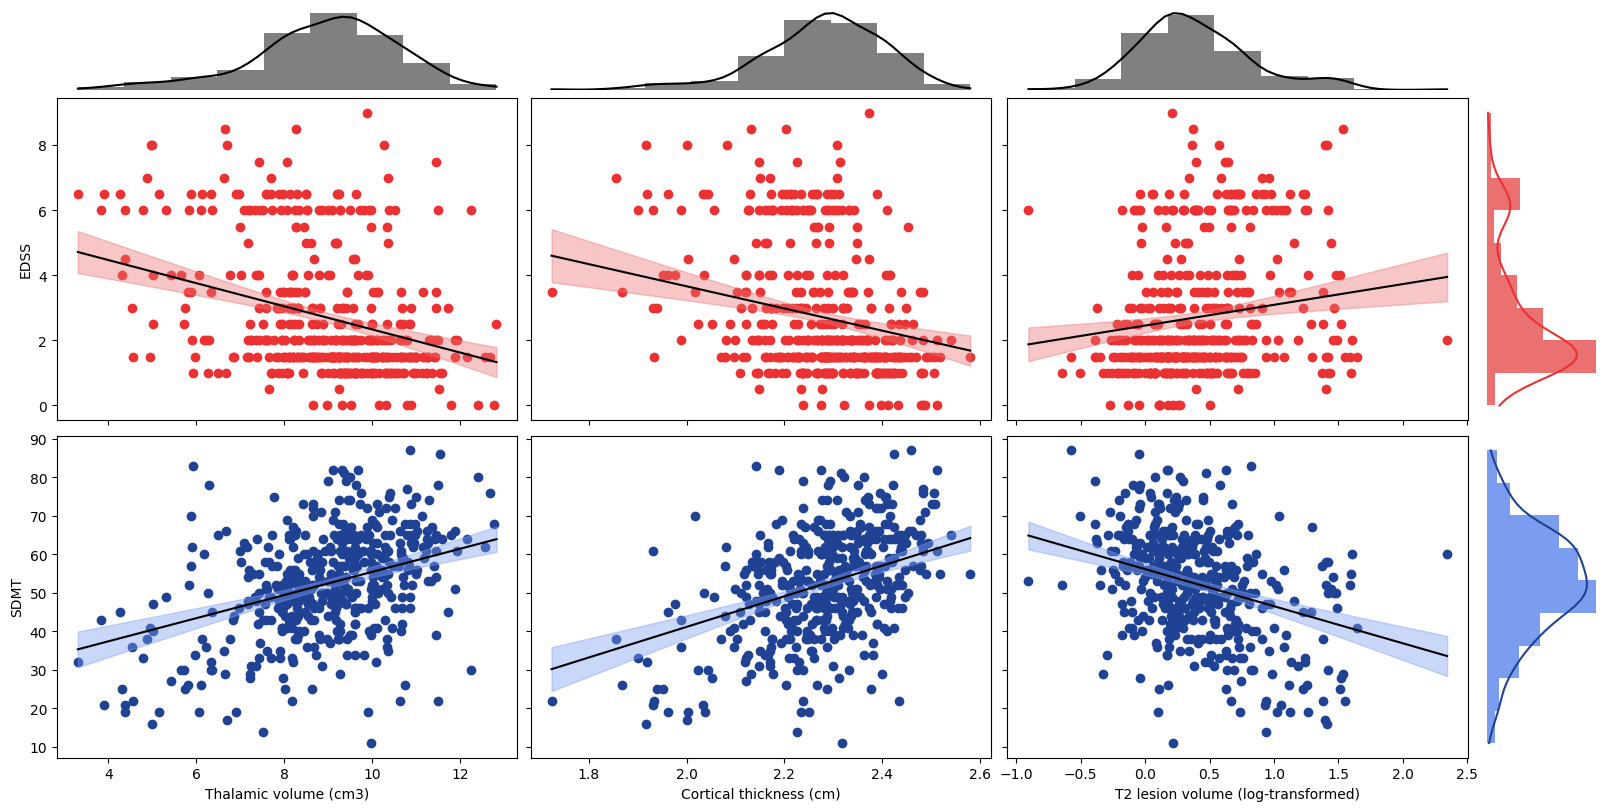

In [6]:
plot_data = df_ms.join([df_thomas])
plot_data['THALAMUS_1'] = plot_data['THALAMUS_1'] / 1000
covariates = ["age", "Female", "tiv"]
nbins=10

fig, axs = plt.subplot_mosaic(
    [['hist_thal', 'hist_ct', 'hist_t2lv', '.'],
    ['edss_thal', 'edss_ct', 'edss_t2lv', 'hist_edss'],
    ['sdmt_thal', 'sdmt_ct', 'sdmt_t2lv', 'hist_sdmt']],
    figsize=(16, 8),
    width_ratios=(4, 4, 4, 1),
    height_ratios=(1, 4, 4),
    layout='constrained'
)

# the histograms
axs['hist_sdmt'].set_axis_off()
axs['hist_edss'].set_axis_off()
axs['hist_thal'].set_axis_off()
axs['hist_ct'].set_axis_off()
axs['hist_t2lv'].set_axis_off()

# EDSS
outcome = "EDSS"

predictor = "THALAMUS_1"
formula = f"{outcome} ~ {predictor} + age + Female + tiv"
res = sm.OLS.from_formula(formula, data=plot_data).fit()
x, y_pred, y_lims = helpers.get_regression_y(plot_data, res, predictor, outcome)
axs['edss_thal'].scatter(plot_data[predictor], plot_data[outcome], color=colors['dark red1'])
axs['edss_thal'].plot(x, y_pred, color="black")
axs['edss_thal'].fill_between(
    x, y_lims[0], y_lims[1], alpha=0.4, color=colors["light red1"]
)
axs['edss_thal'].xaxis.set_major_formatter(plt.NullFormatter())
ylim = axs['edss_thal'].get_ylim()

predictor = "cortical_thickness"
formula = f"{outcome} ~ {predictor} + age + Female + tiv"
res = sm.OLS.from_formula(formula, data=plot_data).fit()
x, y_pred, y_lims = helpers.get_regression_y(plot_data, res, predictor, outcome)
axs['edss_ct'].scatter(plot_data[predictor], plot_data[outcome], color=colors['dark red1'])
axs['edss_ct'].plot(x, y_pred, color="black")
axs['edss_ct'].fill_between(
    x, y_lims[0], y_lims[1], alpha=0.4, color=colors["light red1"]
)
axs['edss_ct'].xaxis.set_major_formatter(plt.NullFormatter())
axs['edss_ct'].yaxis.set_major_formatter(plt.NullFormatter())
axs['edss_ct'].set_ylim(ylim)

predictor = "t2lv_logtrans"
formula = f"{outcome} ~ {predictor} + age + Female + tiv"
res = sm.OLS.from_formula(formula, data=plot_data).fit()
x, y_pred, y_lims = helpers.get_regression_y(plot_data, res, predictor, outcome)
axs['edss_t2lv'].scatter(plot_data[predictor], plot_data[outcome], color=colors['dark red1'])
axs['edss_t2lv'].plot(x, y_pred, color="black")
axs['edss_t2lv'].fill_between(
    x, y_lims[0], y_lims[1], alpha=0.4, color=colors["light red1"]
)
axs['edss_t2lv'].xaxis.set_major_formatter(plt.NullFormatter())
axs['edss_t2lv'].yaxis.set_major_formatter(plt.NullFormatter())

axs['edss_t2lv'].set_ylim(ylim)

y = plot_data['EDSS']
ybins = np.linspace(np.min(y), np.max(y), nbins)
axs['hist_edss'].hist(
    y, bins=ybins, orientation="horizontal", color=colors['light red1'], density=True
)
densityy_edss = stats.gaussian_kde(y.dropna())
xy = np.linspace(np.min(y), np.max(y), 50)
axs['hist_edss'].plot(densityy_edss(xy), xy, color=colors['dark red1'])
axs['hist_edss'].set_ylim(ylim)



# SDMT
outcome = "SDMT"

predictor = "THALAMUS_1"
formula = f"{outcome} ~ {predictor} + age + Female + tiv"
res = sm.OLS.from_formula(formula, data=plot_data).fit()
x, y_pred, y_lims = helpers.get_regression_y(plot_data, res, predictor, outcome)
axs['sdmt_thal'].scatter(plot_data[predictor], plot_data[outcome], color=colors['dark blue1'])
axs['sdmt_thal'].plot(x, y_pred, color="black")
axs['sdmt_thal'].fill_between(
    x, y_lims[0], y_lims[1], alpha=0.4, color=colors["light blue1"]
)
ylim = axs['sdmt_thal'].get_ylim()

predictor = "cortical_thickness"
formula = f"{outcome} ~ {predictor} + age + Female + tiv"
res = sm.OLS.from_formula(formula, data=plot_data).fit()
x, y_pred, y_lims = helpers.get_regression_y(plot_data, res, predictor, outcome)
axs['sdmt_ct'].scatter(plot_data[predictor], plot_data[outcome], color=colors['dark blue1'])
axs['sdmt_ct'].plot(x, y_pred, color="black")
axs['sdmt_ct'].fill_between(
    x, y_lims[0], y_lims[1], alpha=0.4, color=colors["light blue1"]
)
axs['sdmt_ct'].yaxis.set_major_formatter(plt.NullFormatter())
axs['sdmt_ct'].set_ylim(ylim)

predictor = "t2lv_logtrans"
formula = f"{outcome} ~ {predictor} + age + Female + tiv"
res = sm.OLS.from_formula(formula, data=plot_data).fit()
x, y_pred, y_lims = helpers.get_regression_y(plot_data, res, predictor, outcome)
axs['sdmt_t2lv'].scatter(plot_data[predictor], plot_data[outcome], color=colors['dark blue1'])
axs['sdmt_t2lv'].plot(x, y_pred, color="black")
axs['sdmt_t2lv'].fill_between(
    x, y_lims[0], y_lims[1], alpha=0.4, color=colors["light blue1"]
)
axs['sdmt_t2lv'].yaxis.set_major_formatter(plt.NullFormatter())
axs['sdmt_t2lv'].set_ylim(ylim)

y = plot_data['SDMT']
ybins = np.linspace(np.min(y), np.max(y), nbins)
axs['hist_sdmt'].hist(
    y, bins=ybins, orientation="horizontal", color=colors['light blue1'], density=True
)
densityy_sdmt = stats.gaussian_kde(y.dropna())
xy = np.linspace(np.min(y), np.max(y), 50)
axs['hist_sdmt'].plot(densityy_sdmt(xy), xy, color=colors['dark blue1'])
axs['hist_sdmt'].set_ylim(ylim)


# x-axis hists
# Thalamus
x = plot_data['THALAMUS_1']
xbins = np.linspace(np.min(x), np.max(x), nbins)
axs['hist_thal'].hist(x, bins=xbins, color="gray", density=True)
densityx = stats.gaussian_kde(x.dropna())
xx = np.linspace(np.min(x), np.max(x), 50)
axs['hist_thal'].plot(xx, densityx(xx), color="black")

# ct
x = plot_data['cortical_thickness']
xbins = np.linspace(np.min(x), np.max(x), nbins)
axs['hist_ct'].hist(x, bins=xbins, color="gray", density=True)
densityx = stats.gaussian_kde(x.dropna())
xx = np.linspace(np.min(x), np.max(x), 50)
axs['hist_ct'].plot(xx, densityx(xx), color="black")

# t2lv
x = plot_data['t2lv_logtrans']
xbins = np.linspace(np.min(x), np.max(x), nbins)
axs['hist_t2lv'].hist(x, bins=xbins, color="gray", density=True)
densityx = stats.gaussian_kde(x.dropna())
xx = np.linspace(np.min(x), np.max(x), 50)
axs['hist_t2lv'].plot(xx, densityx(xx), color="black")


# Put labels
axs['edss_thal'].set_ylabel("EDSS")
axs['sdmt_thal'].set_ylabel("SDMT")
axs['sdmt_thal'].set_xlabel("Thalamic volume (cm3)")
axs['sdmt_ct'].set_xlabel("Cortical thickness (cm)")
axs['sdmt_t2lv'].set_xlabel("T2 lesion volume (log-transformed)")

plt.savefig(fig_path / "regression_plots_panel.png", dpi=300)

In [93]:
plot_data['thal'] = plot_data['THALAMUS_1'] / plot_data['THALAMUS_1'].mean()
plot_data['ct'] = plot_data['cortical_thickness'] / plot_data['cortical_thickness'].mean()
formula = f"SDMT ~ thal + age + Female + tiv"
res = sm.OLS.from_formula(formula, data=plot_data).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   SDMT   R-squared:                       0.253
Model:                            OLS   Adj. R-squared:                  0.247
Method:                 Least Squares   F-statistic:                     38.09
Date:                Thu, 12 Jun 2025   Prob (F-statistic):           1.88e-27
Time:                        14:30:09   Log-Likelihood:                -1768.0
No. Observations:                 454   AIC:                             3546.
Df Residuals:                     449   BIC:                             3567.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     35.3783      9.070      3.901      0.0

(<Figure size 800x600 with 3 Axes>,
 {'histx': <Axes: label='histx'>,
  'scatter': <Axes: label='scatter'>,
  'histy': <Axes: label='histy'>})

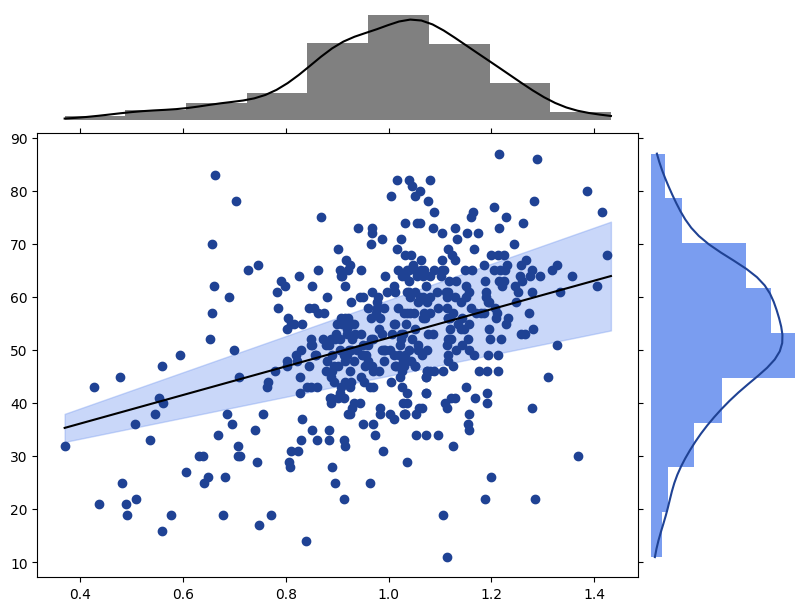

In [95]:
plot_regression(plot_data, 'thal', 'SDMT', ['age', 'Female', 'tiv'])